# Wine Quality Project

### Introduction

This project details the steps taken to create a classifier for predicting the quality of a wine given a set of measured data from a wine sample. We will look at both unsupervised models and supervised models and compare the two for performance and speed in training. The goal of the model is to determine if a wine is high quality or not based on its content and physical attributes.

The goal of this project is to create a wine predictor that will allow people to input measurements about a new wine and determine if it is a high quality wine. The quality score for each wine used in training was derived as the median score between 0-10 given by 3 different wine experts. Since people may have different opinions about the taste of a wine, the quality may be an objective score. In this dataset we determine that any wine with a score of 7 or higher is considered a high quality wine.

### Data

The data was taken from the UCI Machine Learning Repositry Wine Quality Data Set (https://archive.ics.uci.edu/ml/datasets/Wine+Quality). The predictor is given from the `quality` field which is a score from 0-10, however we will need to update this to be a value of 0 or 1 based on its score. There are 11 attributes for each samples and we will use feature selection to narrow down the attributes since there may be several correlated features. There are a total of 6497 wine samples in two different data sets with more white wine samples than red. We will combine the two wines for our models generation and compare it with a model that is trained on the combined dataset. A detailed description of the dataset can be found in the `winequality.names` file included within this project folder.

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


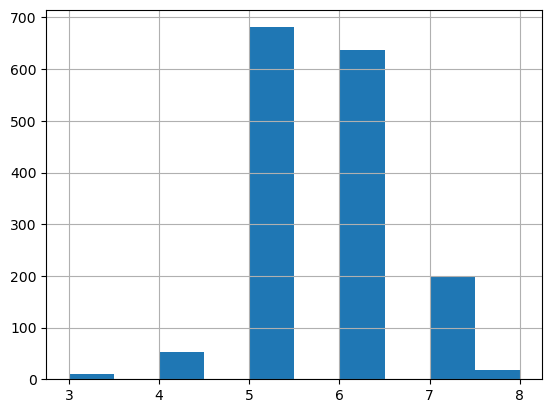

In [8]:
red = pd.read_csv('winequality-red.csv', delimiter=';')
print(red.dtypes)
red.quality.hist()
red.head()

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


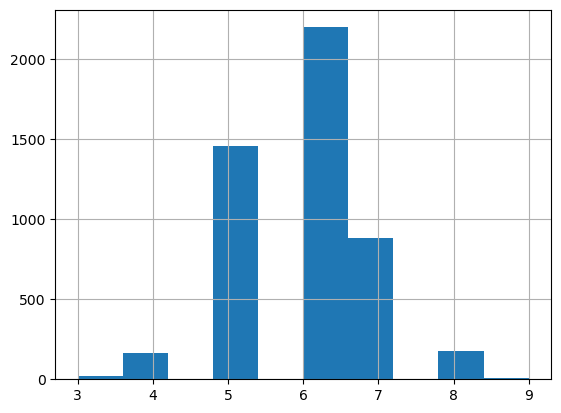

In [9]:
white = pd.read_csv('winequality-white.csv', delimiter=';')
print(white.dtypes)
white.quality.hist()
white.head()

Combine the two datasets into one large set to provide more data points.

In [65]:
print(f"Null Values: {red.isna().sum().sum() + white.isna().sum().sum()}")

# Save quality score into Y value with 1 if score was 7 or greater, 0 otherwise
red_X = red.drop('quality', axis=1)
white_X = white.drop('quality', axis=1)
combined_X = pd.concat([red_X, white_X])

red_Y = np.where(red.quality >= 8, 1, 0)
white_Y = np.where(white.quality >= 8, 1, 0)
combined_Y = np.concatenate([red_Y, white_Y], axis=0)

#combined_X.drop(['density','fixed acidity', 'citric acid', 'free sulfur dioxide'], axis=1, inplace=True)

Null Values: 0


In [70]:
combined_X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


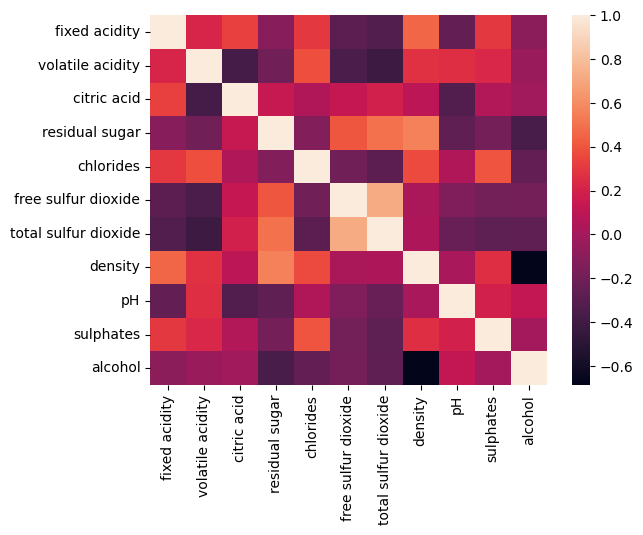

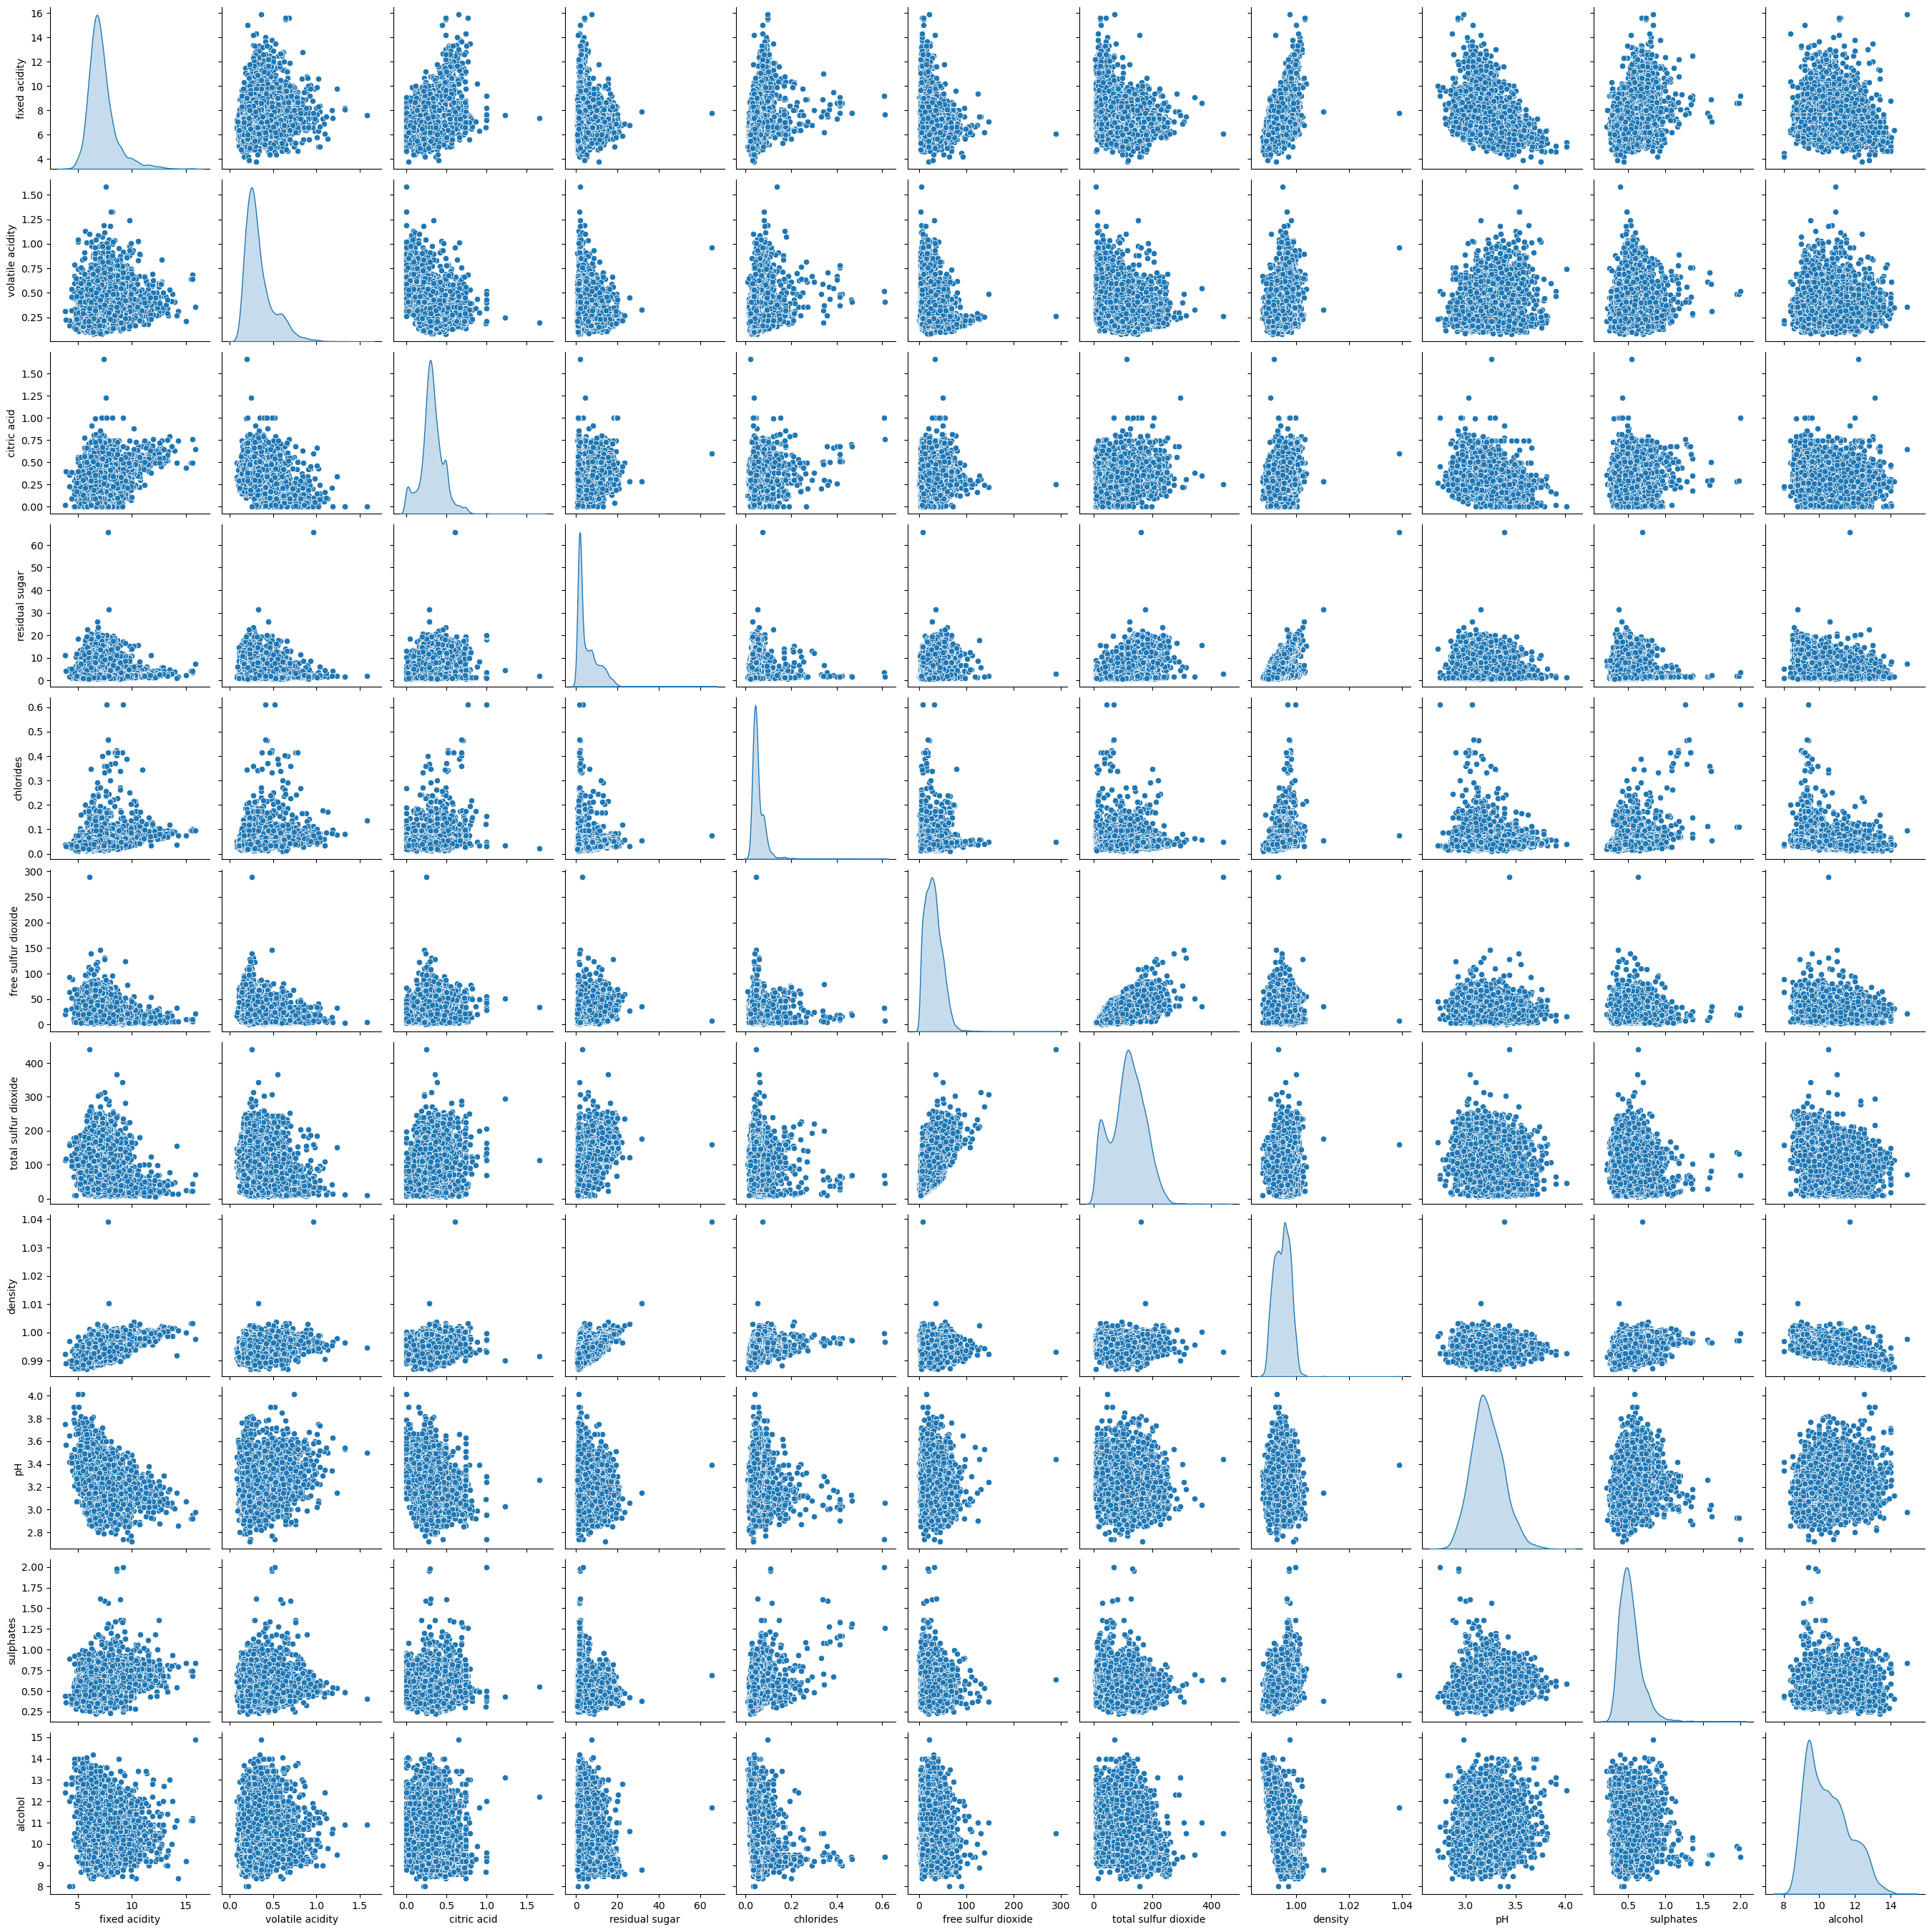

In [125]:
# Plot correlation matrices
sns.heatmap(combined_X.corr())
sns.pairplot(combined_X, diag_kind='kde')

We can see from these correlation plots that there is a strong negative correlation bewteen `density` and `alcohol`, therefore we will remove one of these features before running the data through the model.

In [126]:
combined_X.drop(['density'], axis=1, inplace=True)

### Modeling and Analysis

In this section we will experiment with unsupervised and supervised models and compare performance. We will try to understand why some methods work better than others and what characteristics about the data lend itself to one kind of model over another. Since this is a type of anommaly detections, we will focus on models that have been known to perform well with this task. For the clustering models, we choose a cluster value of 2 to represent the two types of samples we are trying to detect, high quality wines from the normal wines.

In [127]:
cluster = AgglomerativeClustering(n_clusters=2)
labels = cluster.fit_predict(combined_X)

print(f"Score: {accuracy_score(combined_Y, labels)}")
print(f"Balanced Score: {balanced_accuracy_score(combined_Y, labels)}")

Score: 0.5713406187471141
Balanced Score: 0.4731988082123024


Here we looked at the balanced score to account for the fact that there are not as many high quality wines in the dataset. This is a form of anomaly detection where we try to find the points that are farther from the rest since we assume that high quality wines are rare. From the histograms above we see that there are not many wines with a score of 7 or above compared to the dataset as a whole.

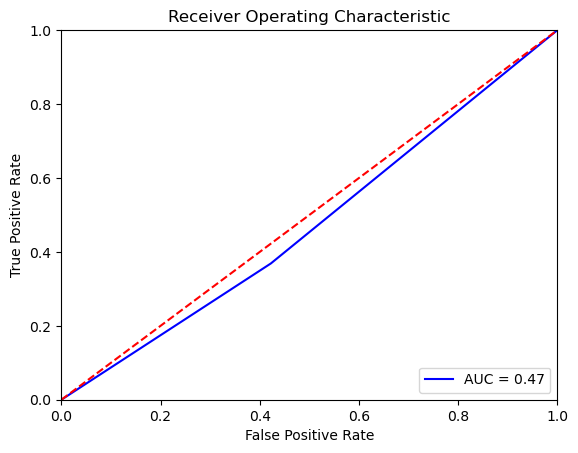

In [128]:
fpr, tpr, threshold = roc_curve(combined_Y, labels)
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Next we will look at another popular clustering algorithm called KMeans for comparison to see if it does any better.

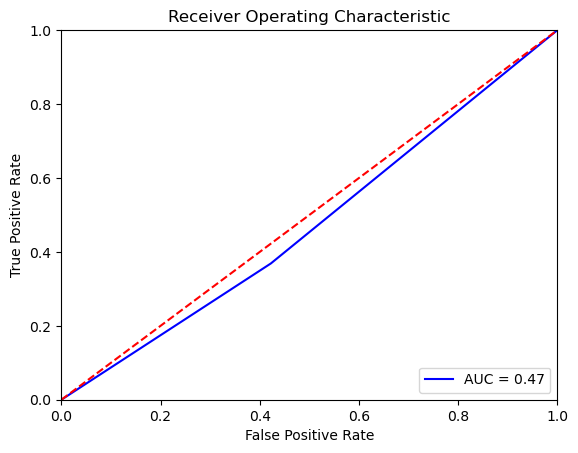

In [134]:
kmeans = KMeans(n_clusters=2)
labels = cluster.fit_predict(combined_X)

fpr, tpr, threshold = roc_curve(combined_Y, labels)
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

This model results in the same numbers as the Agglomerative Clustering method. Finally we will use a supervised learning method for further comparison. This model is a one class SVM which is useful for anommally detection.

{'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'nu': 0.5, 'shrinking': True, 'tol': 0.001, 'verbose': False}


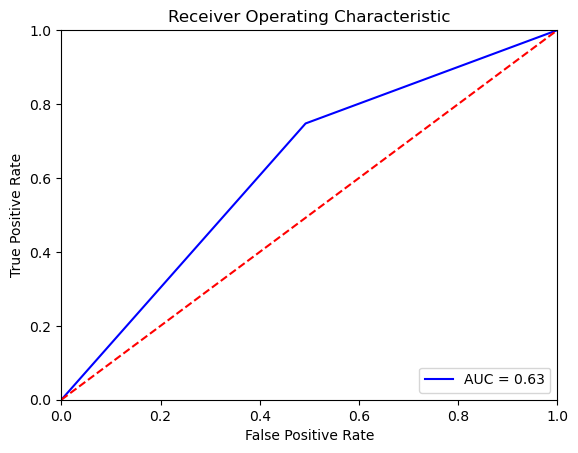

In [140]:
svm = OneClassSVM()
svm_labels = svm.fit_predict(combined_X)
print(svm.get_params())
svm_labels_cleaned = np.ones(svm_labels.shape)
svm_labels_cleaned = np.where(svm_labels == -1, 0, 1)
fpr, tpr, threshold = roc_curve(combined_Y, svm_labels_cleaned)
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Here we perform some hyperparameter tuning to get the best performance using the `balanced_accuracy_score` method as our scoring metric. The results did not produce a model better than the one above.

/home/wyatt/miniconda3/envs/msds/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/wyatt/miniconda3/envs/msds/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 765, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wyatt/miniconda3/envs/msds/lib/python3.11/site-packages/sklearn/metrics/_classification.py", line 2180, in balanced_accuracy_score
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/wyatt/miniconda3/envs/msds/lib/python3.11/site-packages/sklearn/metrics/_classification.py", line 317, in confusion_matrix
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
                             ^^^^^^^^^^^^^^^^^^^^

{'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'nu': 0.5, 'shrinking': True, 'tol': 0.001, 'verbose': False}


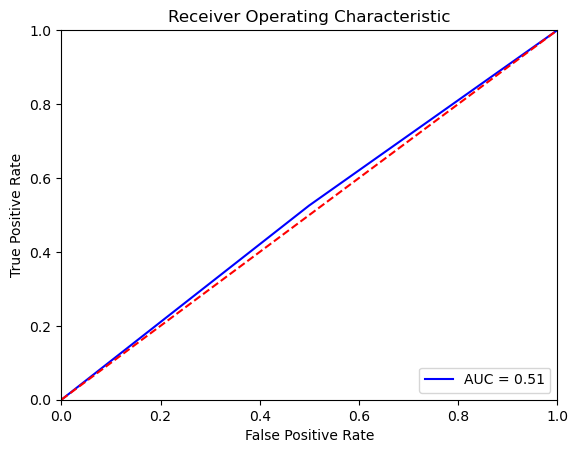

In [142]:
clf = GridSearchCV(OneClassSVM(),
                   param_grid={"kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
                               "gamma": ['scale', 'auto']},
                    scoring=balanced_accuracy_score)
svm_labels = clf.fit(combined_X)

svm = clf.best_estimator_
print(svm.get_params())
svm_labels = svm.fit_predict(combined_X)
svm_labels_cleaned = np.ones(svm_labels.shape)
svm_labels_cleaned = np.where(svm_labels == -1, 0, 1)

fpr, tpr, threshold = roc_curve(combined_Y, svm_labels_cleaned)
roc_auc = auc(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



### Conclusion

We did see better results with the OneClassSVM model than the two unsupervised methods, although even these models performed poorly. It is likely we could have improved the SVM model by scaling different attributes. However, the unsupervised models were trained in about half the time and with further data transformations could have been even faster. It was interesting to note the AUC-ROC curve was less than the 50% line in for the clustering methods, it could have been that the labels were simply backwards or the model was not finding any patterns in the higher dimensions.

### References

1. https://scikit-learn.org/stable/modules/outlier_detection.html